# Importação de Bibliotecas e Carregamento dos Dados


In [5]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Conectar ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Carregar o dataset
df = pd.read_excel('/content/drive/MyDrive/Projeto Aplicado II/Base de dados da Netflix.xlsx')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregamento da Base de Dados Netflix


In [6]:
# Exibir as primeiras linhas do dataset
df.head()


,id,title,type,genre,description
0,1,The Queen’s Gambit 1,Filme,"Crime, Drama",Exploradores viajam pelo espaço em busca de um...
1,2,The Witcher 2,Filme,"Mistério, Ficção Científica",Um grupo de crianças descobre segredos governa...
2,3,Parasite 3,Filme,"Comédia, Romance",Um professor de química do ensino médio se tor...
3,4,Breaking Bad 4,Filme,"Fantasia, Ação",A rotina de um escritório retratada de maneira...
4,5,The Mandalorian 5,Filme,"Fantasia, Ação",Um soldado paraplégico é enviado a um planeta ...


# Sanitização dos Dados e Pré-Processamento (Tokenização, Stopwords, Lematização)


In [7]:
# Pré-processamento dos gêneros
df['genre'] = df['genre'].str.split(', ')


# Análise Exploratória de Dados (Distribuição de Tipos e Gêneros)


<ipython-input-8-a3880b9e3d0d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='Set2')


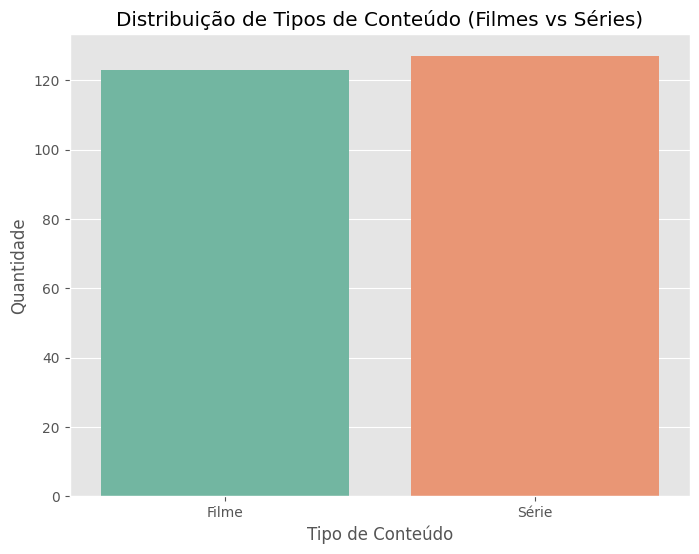

<ipython-input-8-a3880b9e3d0d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=generos.head(10).index, y=generos.head(10).values, palette='Set1')


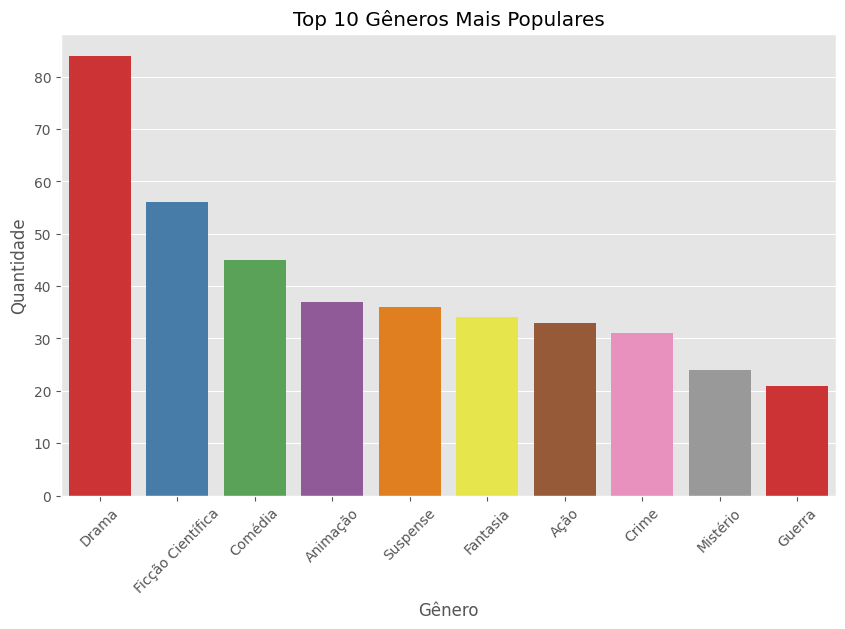

In [8]:
# Distribuição de Tipos de Conteúdo
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type', palette='Set2')
plt.title('Distribuição de Tipos de Conteúdo (Filmes vs Séries)')
plt.xlabel('Tipo de Conteúdo')
plt.ylabel('Quantidade')
plt.show()

# Distribuição dos Gêneros
generos = df['genre'].explode().value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=generos.head(10).index, y=generos.head(10).values, palette='Set1')
plt.title('Top 10 Gêneros Mais Populares')
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()


# Sistema de Recomendação Baseado em Similaridade (TF-IDF + Similaridade do Cosseno)


In [9]:
# Função para recomendar conteúdo baseado em similaridade
def recomendar_conteudo(titulo, top_n=5):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['description'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    idx = df[df['title'] == titulo].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    return df['title'].iloc[indices]

# Exemplo de recomendações
print("Conteúdos recomendados para 'The Witcher 2':")
print(recomendar_conteudo('The Witcher 2'))

print("\nConteúdos recomendados para 'The Queen’s Gambit 1':")
print(recomendar_conteudo('The Queen’s Gambit 1'))


Conteúdos recomendados para 'The Witcher 2':
8                     Dark 9
33    The Big Bang Theory 34
39           The Irishman 40
41        Stranger Things 42
51              Inception 52
Name: title, dtype: object

Conteúdos recomendados para 'The Queen’s Gambit 1':
7      Shutter Island 8
15    Rick and Morty 16
22       Castlevania 23
76         Inception 77
77      Black Mirror 78
Name: title, dtype: object


# Avaliação da Recomendação: Cálculo de Top-N Precision e Recall@K


In [13]:
import numpy as np

# TF-IDF da descrição
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])

# Similaridade de cosseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Função para pegar os top-N recomendados
def get_top_n_recommendations(idx, cosine_sim_matrix, n=5):
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movie_indices

# Simular avaliação
np.random.seed(42)
sample_indices = np.random.choice(df.index, size=10, replace=False)

precision_scores = []
recall_scores = []

for idx in sample_indices:
    true_genres = df.iloc[idx]['genre']
    recommended_indices = get_top_n_recommendations(idx, cosine_sim, n=5)

    recommended_genres = []
    for rec_idx in recommended_indices:
        recommended_genres.extend(df.iloc[rec_idx]['genre'])

    recommended_genres = list(set(recommended_genres))

    # Precision
    relevant_recommendations = [genre for genre in recommended_genres if genre in true_genres]
    precision = len(relevant_recommendations) / len(recommended_genres) if len(recommended_genres) > 0 else 0
    precision_scores.append(precision)

    # Recall
    recall = len(relevant_recommendations) / len(true_genres) if len(true_genres) > 0 else 0
    recall_scores.append(recall)

# Resultados
top_n_precision = np.mean(precision_scores)
recall_at_k = np.mean(recall_scores)

print(f"Top-N Precision: {top_n_precision:.2f}")
print(f"Recall@K: {recall_at_k:.2f}")


Top-N Precision: 0.12
Recall@K: 0.50
